In [1]:
import sys
sys.path.append('../')
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".20"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
import h5py 
import yaml
with open('../system_config.yml','r') as stream:
    sysconfig = yaml.safe_load(stream)

import utils.simulation2d as project
from flowrec.data import DataMetadata
from flowrec.physics_and_derivatives import momentum_residue_field, div_field
from flowrec.losses import divergence
data_dir = Path(sysconfig['data_dir'],'re100')
dt = 0.0002*625

In [2]:
# (ux,uy,pp) = project.read_data(data_dir,idx_body=132)
(ux,uy,pp) = project.read_data(data_dir,idx_body=0)
# take base measurement
pb = project.take_measurement_base(pp, ly=[1.5,2.5] ,centrex=0, domain_y=4)

In [3]:
pp.shape

(800, 513, 129)

## Residue

In [4]:
datainfo = DataMetadata(
    re=100,
    discretisation=[0.125, 12/512, 4/128],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()
(u1,u2,pressure) = project.read_data(data_dir,idx_body=132)
loss_mom = np.mean(
    momentum_residue_field(
        ux=u1[:600,...],
        uy=u2[:600,...],
        p=pressure[:600,...],
        datainfo=datainfo
    )**2
)*2
loss_div = divergence(
    ux=u1[:600,...],
    uy=u2[:600,...],
    datainfo=datainfo
)
lp = loss_mom+loss_div
print(f'The losses of true data - physics {lp}, momentum {loss_mom}, divergence {loss_div}.')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


The losses of true data - physics 0.017341645434498787, momentum 0.017320450395345688, divergence 2.119534110534005e-05.


## Plot data

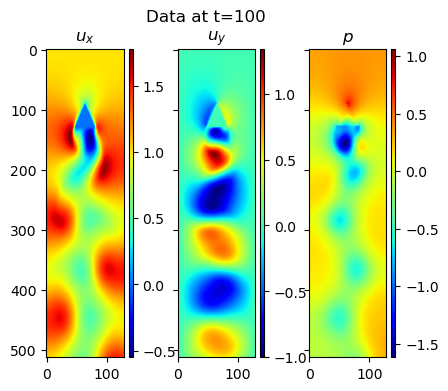

In [5]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Data at t=100')
grid = ImageGrid(fig,111,nrows_ncols=(1,3),cbar_mode='each',axes_pad=0.45,cbar_pad=(0.05))
ax = grid.axes_all
cax = grid.cbar_axes
im0 = ax[0].imshow(ux[100,...],'jet')
cax[0].colorbar(im0)
ax[0].set_title('$u_x$')
im1 = ax[1].imshow(uy[100,...],'jet')
cax[1].colorbar(im1)
ax[1].set_title('$u_y$')
im2 = ax[2].imshow(pp[100,...],'jet')
cax[2].colorbar(im2)
ax[2].set_title('$p$')
plt.show()

In [6]:
probe_location = (150-132,60)
probe_ux = ux[:,probe_location[0],probe_location[1]]
probe_uy = uy[:,probe_location[0],probe_location[1]]
probe_p = pb[:,probe_location[1]-49]

freq = np.fft.fftfreq(len(probe_ux),d=dt)
f_ux = np.fft.fft(probe_ux-np.mean(probe_ux))/len(probe_ux)
f_uy = np.fft.fft(probe_uy-np.mean(probe_uy))/len(probe_uy)
f_p = np.fft.fft(probe_p-np.mean(probe_p))/len(probe_p)

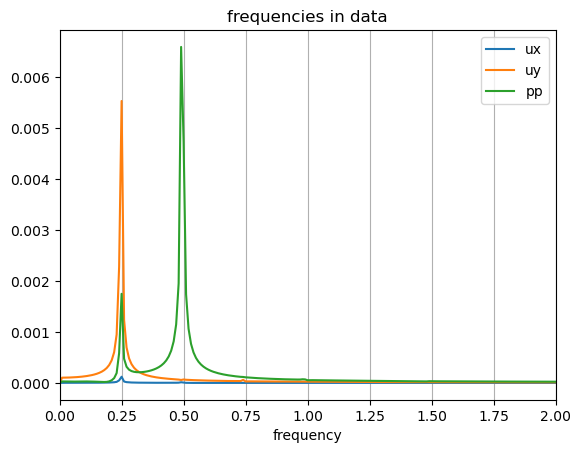

highest peak at  -0.24  Hz.


In [7]:
plt.figure()
plt.plot(freq[:int(len(freq)/2)],np.abs(f_ux)[:int(len(freq)/2)],label ='ux')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_uy)[:int(len(freq)/2)],label ='uy')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_p)[:int(len(freq)/2)],label ='pp')
plt.title('frequencies in data')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.xlim([0,2])
plt.legend()
plt.grid(True, which='both', axis='x')
plt.show()
idx_sort = np.argsort(f_uy)
high_freq = freq[idx_sort][-1]
print("highest peak at ", high_freq, " Hz.")

In [8]:
amp = np.abs(f_uy[idx_sort][-1])
phase = np.angle(f_uy[idx_sort][-1])

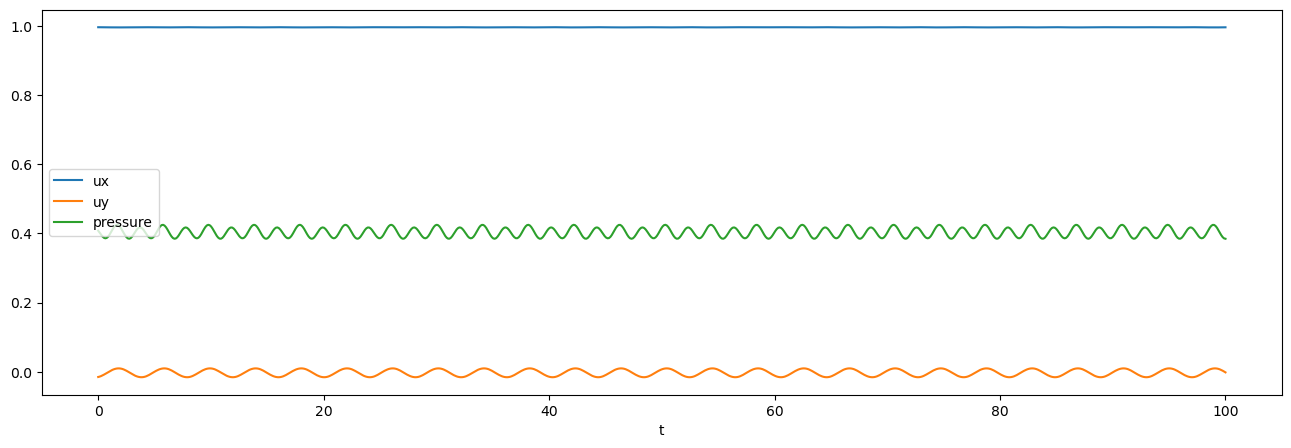

In [9]:
t = np.linspace(0,probe_ux.shape[0]*dt,probe_ux.shape[0])
plt.figure(figsize=(16,5))
# plt.title("$Re=100$")
plt.plot(t,probe_ux,label='ux')
plt.plot(t,probe_uy,label='uy')
plt.plot(t,probe_p,label='pressure')
# plt.plot(t,2*amp*np.cos(high_freq*2*np.pi*t+phase),label='main fft freq')
plt.legend()
# plt.xlim([0,20])
plt.xlabel("t")
plt.show()

# Uz

In [10]:
if Path(data_dir,"uz.h5").exists():
    with h5py.File(Path(data_dir,"uz.h5"),'r') as hf:
        uz = np.array(hf.get('uz'))

In [11]:
t = np.linspace(0,uz.shape[0]*dt,uz.shape[0])
plt.figure(figsize=(16,5))
plt.plot(t,uz[:,150,60],label='uz')
plt.legend()
plt.title('uz')
plt.show()

NameError: name 'uz' is not defined

# Vorticity

In [ ]:
with h5py.File(Path(data_dir,'vort.h5'),'r') as hf:
    vort = np.array(hf.get('vort'))
with h5py.File(Path(data_dir,'critq.h5'),'r') as hf:
    critq = np.array(hf.get('critq'))
vort.shape

(400, 513, 129)

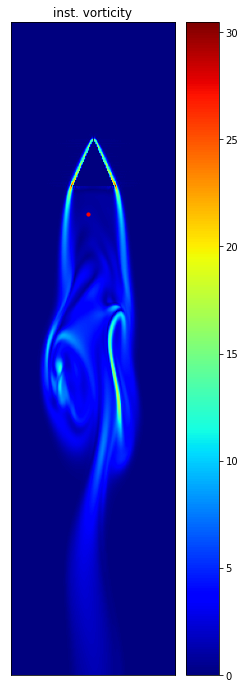

In [ ]:
plt.figure(figsize=(4,12))
plt.title('inst. vorticity')
plt.imshow(vort[200,...],'jet')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.scatter(60,150,s=10,c='r')
plt.show()

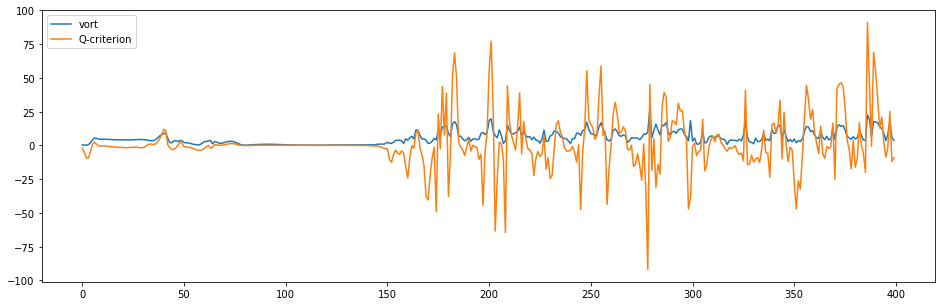

In [ ]:
probe_vort = vort[:,150,60]
probe_q = critq[:,150,60]
plt.figure(figsize=(16,5))
plt.plot(probe_vort,label='vort')
plt.plot(probe_q,label='Q-criterion')
plt.legend()
plt.show()


# Locations of the sensors

In [10]:
triangle_base_coords = [49,80]
(ux_short,uy_short,pp_short) = project.read_data(data_dir, idx_body=132)
# x = np.stack([ux,uy,pp],axis=0)
ux_short.shape

(800, 381, 129)

16


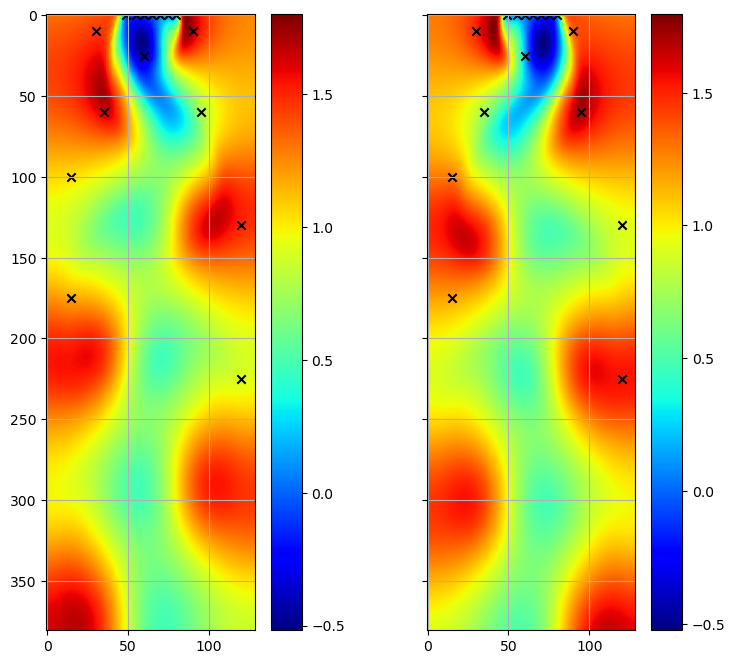

In [16]:
fig,ax = plt.subplots(1,2,figsize=(9,8),sharex=True,sharey=True)
# fig = plt.figure(figsize=(4,8))
im0 = ax[0].imshow(ux_short[500,...],'jet')
plt.colorbar(im0)
ax[0].grid(True, 'both')
im1 = ax[1].imshow(ux_short[0,...],'jet')
plt.colorbar(im1)
ax[1].grid(True, 'both')

# add sensors here
xi = (0, 0, 0, 0, 0, 0, 0, 10,10,25,60,60,100,130,175,225)
yi = (49,55,60,65,70,75,80,30,90,60,35,95, 15,120, 15,120)




sensors = (yi,xi)
ax[0].scatter(*sensors,marker='x',c='k')
ax[1].scatter(*sensors,marker='x',c='k')


print(len(xi))
plt.show()

# Make gif

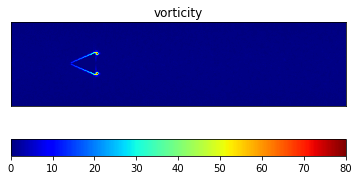

In [ ]:
from matplotlib import animation

fps = 24
sec = 24
plt_data = np.einsum('t x y -> t y x',vort)
fig_gif = plt.figure()
im = plt.imshow(plt_data[0,:,:],vmin =-0.0, vmax=80.0, cmap='jet')
# im = plt.imshow(plt_data[0,:,:], cmap='jet')
plt.colorbar(orientation='horizontal')
plt.title('vorticity')
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
def animation_fun(i):
    im.set_array(plt_data[i,:,:])
    return[im]

# gif = animation.FuncAnimation(fig_gif,
#                                 animation_fun,
#                                 frames=np.arange(fps*sec),
#                                 interval=1000/fps,
#                                 repeat=False)
# gif.save('data_animation.gif',fps=fps)

MovieWriter ffmpeg unavailable; using Pillow instead.
